# 13.4 Nonlinear Autoencoder Using Neural Networks 

In [1]:
import numpy as np

In [7]:
from matplotlib import gridspec

In [ ]:
#datapath = '/users/jazz13/Desktop/GitHub_Files/435-deep-learning/'

In [2]:
datapath = '/home/venkat/Desktop/GitHub_Files/435-deep-learning/'

In [3]:
import matplotlib.pyplot as plt

# import data
X = np.loadtxt(datapath + 'universal_autoencoder_samples.csv', delimiter=',')

plt.scatter(X[0,:], X[1,:], c = 'k', s = 60, linewidth = 0.75, edgecolor = 'w')
plt.show()

<Figure size 640x480 with 1 Axes>

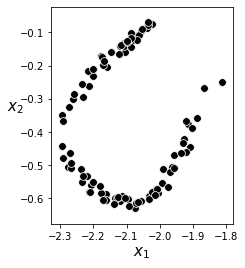

In [8]:
# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0],aspect = 'equal');
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X[0,:],X[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w')
plt.show()

# 13.8 Batch Normalization 

In [9]:
# get MNIST data from online repository
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

print(np.shape(x))
print(np.shape(y))

(70000, 784)
(70000, 1)


# 13.9 Early Stopping Cross-Validation

In [10]:
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname, delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]

print(np.shape(x))
print(np.shape(y))


OSError: /home/venkat/Desktop/GitHub_Files/435-deep-learning/noisy_sin_sample.csv not found.

# 13.10 Hand Written Digit Recognition Using Neural Networks 

In [ ]:
# get MNIST data from online repository
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

print(np.shape(x))
print(np.shape(y))